# k-thermocouple datalogger and plotter
This is a plotter for k-type thermocouple data loggers. 
The thermocouple is connected to an arduino uno via an amplifier chip: MAX31855 ver. 2. The chip is provided with a cold-junction die which acts as a reference for the chip when it calculates volts -> temperature. 

The temperature is calculated via software in the arduinon (can use hardware conversion as well) and sent from the arduino via serial port to the laptop.

As soon as any software listens to the serial port, the program on the arduinon first starts a new test and then it sends data points (cold-junction temperature and thermocouple temperature respectively) 2 times/s, i.e. the data points are sent at 0.5 s intervals.

Putty reads the serial port and logs the data in a text file, ktemp.log.

The Python code/jupyter notebook reads the file and ignores all data linked to test and previous, and sends temperature data from elements and from cold-junction to a figure.


<img src="https://gitlab.com/knjakob-blomquist/kcouple-data-logger/-/raw/main/arduino.jpg?inline=false" alt="photo" width=500 >
<em>Close up of Arduino and MAX31855 setup:</em>

1. Make sure that the connectors are correctly connected from max31855 to arduino. 5V and Ground from arduino analog to port 6 and 4 on MAX31855. Port 3, 4, and 5 on arduino digital to port 1 (CLK), 2(CS), and 3(DO) on MAX31855.  

2. Connect USB cable to arduino and laptop

3. Start Putty and run "thermo" file

4. When the temperatures seem stable, restart Putty, then the temp graph will restart from zero.

5. Start the python code

When you are finished, you can retrieve the data from the file and save or analyse it afterwards.

In [1]:
# For animations in jupyter notebook
# you need a backend like qt, qt5, tk etc.
# which will pop out plots in separate window
# You can try just %matplotlib (without any defined backend)
# I just needed qt5 for me.

# %matplotlib
# %matplotlib tk
# %matplotlib qt5
%matplotlib qt

In [2]:
# Read data from log-file
import matplotlib.pyplot as plt

import numpy as np
from matplotlib.animation import FuncAnimation


plt.style.use(['science','notebook', 'grid']) 

def report_iterator():
    '''Iterator filter function
    Opens text file with temperature data
    and ignore all lines until actual data
    then returns string content of each lines as an iterator
    '''
    with open("/home/jakob/Arduino/k-couple/ktemp.log", "r") as myfile:
        for line in myfile:
            if "Internal" in line:
                break
        for line in myfile:
            yield line

def calibrate(data, rawlow=1.0, rawhigh=101.25):
    '''
    Use previous 2-point calibration measurement
    to provide internal calibration of data. Update rawlow
    and rawhigh if you make new calibration.
    '''
    data = np.array(data)
    refLow = 0.01
    refHigh = 100
    refRange = refHigh - refLow
    rawRange = rawhigh - rawlow
    
    calibrated_data = np.around(((data - rawlow)*refRange)/rawRange + refLow, 1)
    
    return calibrated_data


def read_data():
    '''Convert strings from lines into lists of
    floats
    
    return time, k-couple temp, cold junction temp
    '''
    tInt = []
    temp = []
    for line in report_iterator():
        Temp = float(line.split(sep=",")[1])
        itemp = float(line.split(sep=",")[0])
        temp.append(Temp)
        tInt.append(itemp)
        
    t = np.linspace(0, 0.5*(len(temp)-1), len(temp))
    return t, temp, tInt


def animate(i):
    '''
    Standard animator function needed by
    FuncAnimation
    
    Plots temperature
    '''
    # read data from file
    t, temp, itemp = read_data()
    
    # comment out if you want uncalibrated data
    temp = calibrate(data=temp)
    
    # print values of current temp as label 
    s1 = "Temp: "+str(temp[-1])+r'$\degree$ C'
    s2 = "Cold Junction: "+str(round(itemp[-1], 1))+r'$\degree$ C'
    
    # clear current axes in every loop
    plt.cla()
    
    # create plot
    plt.plot(t, temp, label=s1)
    plt.plot(t, itemp, label=s2)
    plt.legend(loc="upper left", 
               facecolor = "white",
               fontsize=16)
    plt.ylim(min(min(itemp),min(temp)) - 1, max(max(itemp),max(temp)) + 3) 
    plt.ylabel(r'Temp / $\degree$ C')
    plt.xlabel('Tid / s')
    plt.tight_layout()
    
# interval is in miliseconds. Arduino is set to read and
# send data (approx) once every 500 ms at the moment. All that data is saved
# by Putty. It's often fine updating plot 1 time / second. 
# All the data will still show up from the log-file.
ani = FuncAnimation(plt.gcf(), animate, interval=1000)

plt.tight_layout()
plt.show()

## Analyse data
Once the measurement is complete, we can analyse the data however we want, including saving it to a csv file.

<img src="https://gitlab.com/knjakob-blomquist/kcouple-data-logger/-/raw/main/analysedata.png?inline=false" alt="graph" width=500 >
<em>Example of temperature curve from Python code</em>


Following code will read the data directly from the data objects generated by the previous script, then it will save it into a csv-file.

In [3]:
# Analyse data / Data processing
# Save Calibrated Data in csv file
import csv

fieldnames = ['tid', 'temp', 'cj-temp']
t, temp, itemp = read_data()

temp = calibrate(data=temp)

# spara data i csv-fil
with open('/home/jakob/Arduino/k-couple/temp-data.csv', 'w') as csvfile:
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer2 = csv.writer(csvfile)
    csv_writer2.writerows(np.array([t, temp, itemp]).T)


## 2-point calibration

To perform a two point calibration:

1. Take two measurements with your sensor:  One near the low end of the measurement range and one near the high end of the measurement range. 
2. Record these readings as "RawLow" and "RawHigh"
3. Repeat these measurements with your reference instrument.
4. Record these readings as "ReferenceLow" and "ReferenceHigh"
5. Calculate "RawRange" as RawHigh – RawLow.
6. Calculate "ReferenceRange" as ReferenceHigh – ReferenceLow
7. In your code, calculate the "CorrectedValue" using the formula below:

$$CorrectedValue = \frac{(RawValue - RawLow) \cdot ReferenceRange}{ RawRange} + ReferenceLow$$

A common example of a two-point calibration is to calibrate a temperature sensor using an ice-water bath and boiling water for the two references.   Thermocouples and other temperature sensors are quite linear within this temperature range, so two point calibration should produce good resuts.

<img src="https://gitlab.com/knjakob-blomquist/kcouple-data-logger/-/raw/main/calibration_photo.jpg?inline=false" alt="photo" width=500 >
<em>2-point calibration using ice-water and boiling water:</em>

Since these are physical standards, we know that at normal sea-level atmospheric pressure, water boils at 100°C and the "triple point" is 0.01°C.  We can use these known values as our reference values:

**ReferenceLow = 0.01°C**

**ReferenceHigh = 100°C**

**ReferenceRange = 99.99**

Let's say we perform the reading and our "Raw" readings are:

**RawLow = -0.5°C**

**RawHigh = 96.0°C**

**RawRange = 96.5°C**

So, if we get a raw reading of 37°C with this thermometer, we can plug the numbers into the equation to get the corrected reading:

$\frac{(37 + 0.5)\cdot 99.99}{ 96.5} + 0.01 = 38.9$°C

## Example code for analysis

In [4]:
%matplotlib inline

Tmin before calibration = 23.75
Tmax before calibration = 36.0
Tmin after calibration = 22.7
Tmax after calibration = 34.9


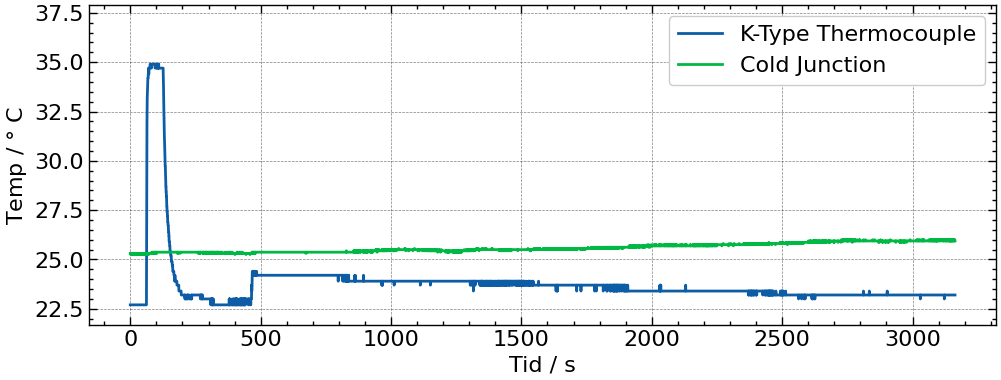

In [5]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import numpy as np

rcParams.update(rcParamsDefault)

plt.style.use(['science','notebook', 'grid']) 

def report_iterator():
    '''Iterator filter function
    Opens text file with temperature data
    and ignore all lines until actual data
    then returns string content of each lines as an iterator
    '''
    with open("/home/jakob/Arduino/k-couple/ktemp.log", "r") as myfile:
        for line in myfile:
            if "Internal" in line:
                break
        for line in myfile:
            yield line

def read_data():
    '''Convert strings from lines into lists of
    floats
    
    return time, k-couple temp, cold junction temp
    '''
    tInt = []
    temp = []
    for line in report_iterator():
        Temp = float(line.split(sep=",")[1])
        itemp = float(line.split(sep=",")[0])
        temp.append(Temp)
        tInt.append(itemp)
        
    t = np.linspace(0, 0.5*(len(temp)-1), len(temp))
    return t, temp, tInt

def calibrate(data, rawlow=1.0, rawhigh=101.25):
    '''
    Use previous 2-point calibration measurement
    to provide internal calibration of data. Update rawlow
    and rawhigh if you make new calibration.
    '''
    data = np.array(data)
    refLow = 0.01
    refHigh = 100
    refRange = refHigh - refLow
    rawRange = rawhigh - rawlow
    
    calibrated_data = np.around(((data - rawlow)*refRange)/rawRange + refLow, 1)
    
    return calibrated_data

# Read data from log-file
t, temp, itemp = read_data()

print(f'Tmin before calibration = {min(temp)}')
print(f'Tmax before calibration = {max(temp)}')

# recalculate temperature using 2-point calibration
cal_temp = calibrate(data=temp)

print(f'Tmin after calibration = {min(cal_temp)}')
print(f'Tmax after calibration = {max(cal_temp)}')

s1 = 'K-Type Thermocouple'
s2 = 'Cold Junction'

fig = plt.figure(figsize=(10, 4))
plt.plot(t, cal_temp, label=s1)
plt.plot(t, itemp, label=s2)
plt.legend(loc="best", 
           facecolor = "white",
           fontsize=16)
plt.ylim(min(min(itemp),min(cal_temp)) - 1, max(max(itemp),max(cal_temp)) + 3) 
plt.ylabel(r'Temp / $\degree$ C')
plt.xlabel('Tid / s')
plt.tight_layout()
plt.show()